In [54]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

In [92]:
def normalize(b, epsilon=1e-16):
    u = b / torch.sqrt((b * b).sum(1, keepdim=True)).clip(min=epsilon)
    return u

def norm_squared(a):
    return torch.square(a).sum(1, keepdim=True)

def min_norm_proj(a,b, M=None, epsilon=1e-10):

    baM = torch.einsum("bi,bij->bj", b-a, M) if M is not None else b-a

    gamma = (baM * b).sum(1, keepdim=True) / (baM * baM).sum(1,keepdim=True).clip(min=epsilon**2)
    gamma = gamma.clip(min=0,max=1)
    #c = a * gamma + (1 - gamma) * b
    c = b * gamma + (1 - gamma) * a
    return c, gamma


def truncated_proj_a_on_b(a,b, epsilon=1e-16):
    u = normalize(b, epsilon)
    prob_a_on_b = - torch.relu(- (a * u).sum(1, keepdim=True)) * u
    #a_proj_on_b = -torch.relu(- (a * u).sum(1, keepdim=True)) * u
    return a - prob_a_on_b

def frank_work_algorithm(g_list, n_iter=None):
    n_tasks = len(g_list)
    B, N = g_list[0].shape
    device = g_list[0].device
    dtype = g_list[0].dtype
    
    if n_iter is None: n_iter = n_tasks * 2

    alpha = torch.ones((B, n_tasks,), device=device, dtype=dtype) / n_tasks
    grads = torch.stack(g_list, -1)
    M = torch.einsum("bik,bil->bkl", grads, grads)
    for i in range(n_iter):
        al_M = torch.einsum("bl,bkl->bk", alpha, M)
        t = torch.argmin(al_M, 1)
        e = nn.functional.one_hot(t, n_tasks)
        alpha, gamma = min_norm_proj(alpha, e)
        print(f"gamma: {gamma}")

    return alpha

(-0.04983409217545251,
 1.0465159356845026,
 -1.1171195414380959,
 1.3251610319712477)

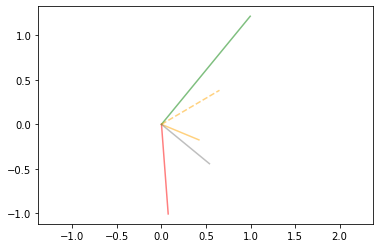

In [129]:
a = torch.tensor(np.random.randn(2)).unsqueeze(0)
b = torch.tensor(np.random.randn(2)).unsqueeze(0)

_, gamma = min_norm_proj(a, b)
c1 = a * gamma + (1 - gamma) * b
c1p = b * gamma + (1 - gamma) * a
c2 = truncated_proj_a_on_b(a, b)

R = np.array([[0, -1], [1.,0]])
R = torch.tensor(R)

def plot_vector(vector, color, **kwargs):
    v = vector.squeeze(0).detach().cpu().numpy()
    plt.plot([0, v[0]], [0,v[1]], color=color, alpha=0.5, **kwargs)

plot_vector(a, "red")
plot_vector(b, "green")
plot_vector(c1, "orange")
plot_vector(c1p, "orange", linestyle="--")
plot_vector(c2, "gray")

plt.axis('equal')



gamma: tensor([[1.0000]], dtype=torch.float64)
gamma: tensor([[1.]], dtype=torch.float64)
gamma: tensor([[1.]], dtype=torch.float64)
gamma: tensor([[1.]], dtype=torch.float64)
gamma: tensor([[1.]], dtype=torch.float64)
gamma: tensor([[1.]], dtype=torch.float64)
gamma: tensor([[1.]], dtype=torch.float64)
gamma: tensor([[1.]], dtype=torch.float64)
gamma: tensor([[1.]], dtype=torch.float64)
gamma: tensor([[1.]], dtype=torch.float64)


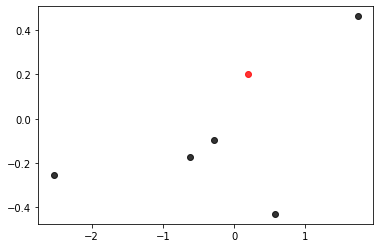

In [91]:
K = 5
a_list = [torch.tensor(np.random.randn(2)).unsqueeze(0) for _ in range(K)]
c = frank_work_algorithm(a_list)

plt.scatter(x=[a[0,0] for a in a_list], y=[a[0,1] for a in a_list], color="black", alpha=0.8)
plt.scatter(x=[c[0,0]], y=[c[0,1]], color="red", alpha=0.8)

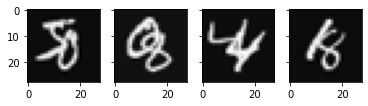

In [156]:
from utils.multi_mnist_dataset import MultiMNIST
from torchvision import transforms

global_transformer = transforms.Compose(
        [transforms.Normalize((0.1307, ), (0.3081, ))])


dataset = MultiMNIST("./dataset",
                           train=True,
                           download=True,
                           transform=global_transformer,
                           multi=True)

fig, ax_list = plt.subplots(1,4, sharex=True, sharey=True)
for i in range(len(ax_list)):
    x  = dataset[i][0].squeeze()
    ax_list[i].imshow(x, cmap="gray")
fig.savefig("figures/digits.png")